In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

### 📊 Deskripsi Fitur Dataset (FloodGuard)
Dataset ini berisi data historis cuaca dan kondisi tanah per jam (hourly) yang diperoleh melalui Open-Meteo Archive API.

| Nama Fitur | Tipe Data | Satuan | Deskripsi |
| :--- | :--- | :--- | :--- |
| **date** | Datetime | - | Timestamp waktu pengamatan (Asia/Jakarta) |
| **total_precipitation** | Float64 | mm | Total presipitasi (hujan, salju, es) per jam |
| **rain_only** | Float64 | mm | Jumlah curah hujan cair per jam |
| **soil_moisture_0_7cm** | Float64 | m³/m³ | Kadar air tanah lapisan permukaan (0-7 cm) |
| **soil_moisture_7_28cm** | Float64 | m³/m³ | Kadar air tanah lapisan dangkal (7-28 cm) |
| **soil_moisture_28_100cm** | Float64 | m³/m³ | Kadar air tanah lapisan menengah (28-100 cm) |
| **soil_moisture_100_255cm**| Float64 | m³/m³ | Kadar air tanah lapisan dalam (100-255 cm) |
| **surface_pressure** | Float64 | hPa | Tekanan udara di permukaan |
| **humidity** | Float64 | % | Kelembapan relatif pada ketinggian 2 meter |

### 0. Load & Merging

In [2]:
# 1. Load & Merge Data
files = glob.glob("../data/raw/*.csv")
df = pd.concat([pd.read_csv(f) for f in files])

# df['date'] = pd.to_datetime(df['date'])
# df = df.sort_values('date').reset_index(drop=True)

print(f"Data Loaded: {df.shape[0]} baris")
df.head()

Data Loaded: 17544 baris


,date,total_precipitation,rain_only,soil_moisture_0_7cm,soil_moisture_7_28cm,soil_moisture_28_100cm,soil_moisture_100_255cm,surface_pressure,humidity
0,2024-01-01 00:00:00+07:00,0.0,0.0,0.493,0.488,0.334,0.396,1008.01953,97.34929
1,2024-01-01 01:00:00+07:00,0.0,0.0,0.492,0.488,0.334,0.396,1007.51870,97.63635
2,2024-01-01 02:00:00+07:00,0.0,0.0,0.491,0.487,0.335,0.396,1007.01660,98.51197
3,2024-01-01 03:00:00+07:00,0.0,0.0,0.490,0.487,0.335,0.396,1007.01660,98.80800
4,2024-01-01 04:00:00+07:00,0.0,0.0,0.489,0.486,0.335,0.396,1006.91620,98.51087


In [3]:
df.isnull().sum()

date                       0
total_precipitation        0
rain_only                  0
soil_moisture_0_7cm        0
soil_moisture_7_28cm       0
soil_moisture_28_100cm     0
soil_moisture_100_255cm    0
surface_pressure           0
humidity                   0
dtype: int64

### 1. Data Preprocessing

In [4]:
# Pastikan date bertipe datetime dan hapus informasi timezone
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.tz_localize(None)

df.head(2)

,date,total_precipitation,rain_only,soil_moisture_0_7cm,soil_moisture_7_28cm,soil_moisture_28_100cm,soil_moisture_100_255cm,surface_pressure,humidity
0,2024-01-01 00:00:00,0.0,0.0,0.493,0.488,0.334,0.396,1008.01953,97.34929
1,2024-01-01 01:00:00,0.0,0.0,0.492,0.488,0.334,0.396,1007.51870,97.63635


### 2. Feature Engineering

In [5]:
# --- 1. FEATURE SELECTION & ROLLING ---
# Menghitung rata-rata kelembapan tanah di seluruh lapisan
df['soil_moisture_avg'] = df[['soil_moisture_0_7cm', 'soil_moisture_7_28cm', 
                               'soil_moisture_28_100cm', 'soil_moisture_100_255cm']].mean(axis=1)
# Akumulasi hujan 6 jam terakhir (indikator genangan)
df['rain_sum_6h'] = df['total_precipitation'].rolling(window=6).sum()
# Interaksi Hujan & Tanah (Indikator Genangan)
df['hydro_saturation_index'] = df['total_precipitation'] * df['soil_moisture_0_7cm']

# --- 2. TIME-LAG FEATURES ---
# Apa yang terjadi 1 jam, 3 jam, 6 jam yang lalu?
for i in [1, 3, 6]:
    df[f'rain_lag_{i}h'] = df['total_precipitation'].shift(i)
    df[f'soil_lag_{i}h'] = df['soil_moisture_avg'].shift(i)

# --- 3. MULTI-LEVEL TARGET LABELING (Untuk Notifikasi) ---
# Kita buat label 0-3 untuk notifikasi bertingkat 3 jam ke depan
def get_alert_level(future_rain):
    if future_rain > 20: return 3   # Darurat (Hujan Ekstrem)
    if future_rain > 10: return 2   # Siaga (Hujan Lebat)
    if future_rain > 2:  return 1   # Waspada (Hujan Sedang)
    return 0                        # Aman

# Shift data masa depan untuk dipelajari
df['future_rain_val'] = df['total_precipitation'].shift(-3)
df['target_alert_level'] = df['future_rain_val'].apply(get_alert_level)

# Kita ingin memprediksi: Apakah 3 jam ke depan curah hujan > 10mm (Hujan Lebat)?
# Shift -3 berarti kita menarik data masa depan ke baris saat ini untuk dipelajari AI
# df['target_is_heavy_rain'] = (df['total_precipitation'].shift(-3) > 10).astype(int)

# --- 4. CLEANING ---
# Hapus kolom pembantu dan baris NaN
df = df.drop(columns=['future_rain_val']).dropna()

print("Feature Engineering Selesai!")
print(f"Jumlah Fitur Sekarang: {len(df.columns)}")

Feature Engineering Selesai!
Jumlah Fitur Sekarang: 19


In [6]:
df

,date,total_precipitation,rain_only,soil_moisture_0_7cm,soil_moisture_7_28cm,soil_moisture_28_100cm,soil_moisture_100_255cm,surface_pressure,humidity,soil_moisture_avg,rain_sum_6h,hydro_saturation_index,rain_lag_1h,soil_lag_1h,rain_lag_3h,soil_lag_3h,rain_lag_6h,soil_lag_6h,target_alert_level
6,2024-01-01 06:00:00,0.0,0.0,0.488,0.485,0.336,0.396,1008.01390,97.626724,0.42625,0.0,0.0000,0.0,0.42600,0.0,0.42700,0.0,0.42775,0
7,2024-01-01 07:00:00,0.0,0.0,0.487,0.484,0.336,0.396,1008.82050,93.085330,0.42575,0.0,0.0000,0.0,0.42625,0.0,0.42650,0.0,0.42750,0
8,2024-01-01 08:00:00,0.0,0.0,0.490,0.485,0.336,0.396,1008.83514,84.486946,0.42675,0.0,0.0000,0.0,0.42575,0.0,0.42600,0.0,0.42725,0
9,2024-01-01 09:00:00,0.1,0.1,0.489,0.485,0.336,0.396,1009.34480,74.259026,0.42650,0.1,0.0489,0.0,0.42675,0.0,0.42625,0.0,0.42700,0
10,2024-01-01 10:00:00,0.1,0.1,0.488,0.484,0.337,0.396,1009.25100,70.293070,0.42625,0.2,0.0488,0.1,0.42650,0.0,0.42575,0.0,0.42650,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,2025-12-31 19:00:00,0.0,0.0,0.359,0.276,0.265,0.382,1005.92040,89.725950,0.32050,6.5,0.0000,0.1,0.34275,2.0,0.34325,0.3,0.32650,1
428,2025-12-31 20:00:00,0.9,0.9,0.368,0.276,0.265,0.382,1006.52050,87.059586,0.32275,3.3,0.3312,0.0,0.32050,0.2,0.34300,4.1,0.33850,0
429,2025-12-31 21:00:00,1.9,1.9,0.391,0.276,0.265,0.382,1006.91296,93.571030,0.32850,5.1,0.7429,0.9,0.32275,0.1,0.34275,0.1,0.33800,0
430,2025-12-31 22:00:00,4.8,4.8,0.455,0.276,0.265,0.382,1007.71070,95.572900,0.34450,7.9,2.1840,1.9,0.32850,0.0,0.32050,2.0,0.34325,0


In [7]:
df['target_alert_level'].value_counts()

target_alert_level
0    16805
1      704
2       28
3        1
Name: count, dtype: int64

In [12]:
df.columns

Index(['date', 'total_precipitation', 'rain_only', 'soil_moisture_0_7cm',
       'soil_moisture_7_28cm', 'soil_moisture_28_100cm',
       'soil_moisture_100_255cm', 'surface_pressure', 'humidity',
       'soil_moisture_avg', 'rain_sum_6h', 'hydro_saturation_index',
       'rain_lag_1h', 'soil_lag_1h', 'rain_lag_3h', 'soil_lag_3h',
       'rain_lag_6h', 'soil_lag_6h', 'target_alert_level'],
      dtype='object')

In [8]:
output_dir = "../data/processed"
os.makedirs(output_dir, exist_ok=True)

df.to_csv(f"{output_dir}/final_data.csv", index=False)
print(f"✅ File berhasil disimpan di: {output_dir}/final_data.csv")

✅ File berhasil disimpan di: ../data/processed/final_data.csv


### 3. EDA

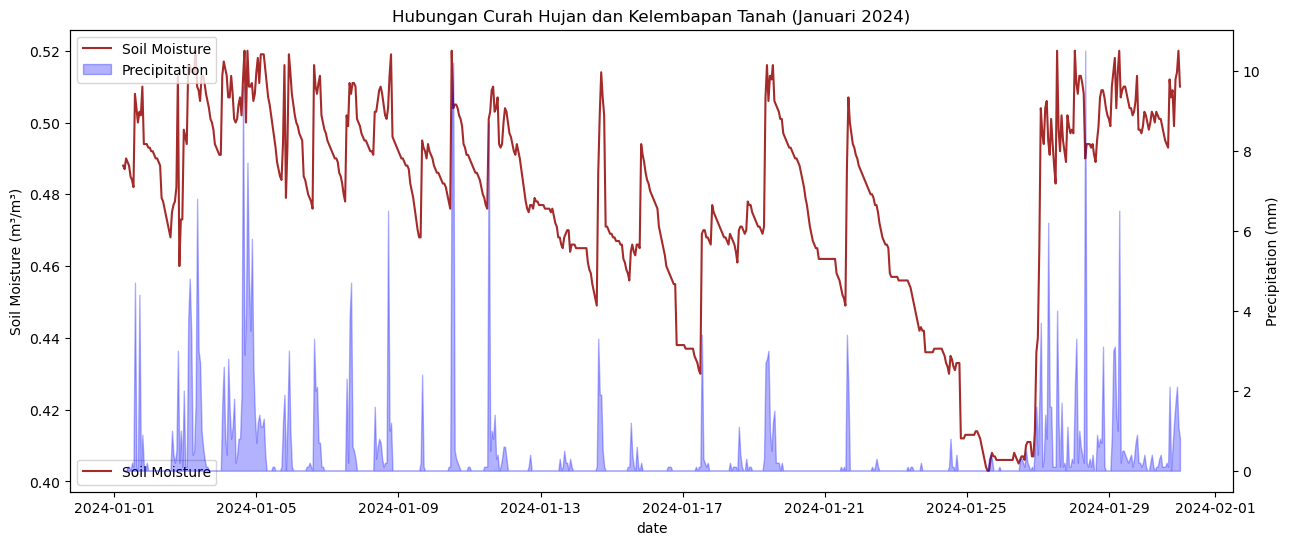

In [9]:
# Ambil sampel data 1 bulan untuk melihat detail (Misal: Januari 2024 saat hujan tinggi)
jan_data = df[(df['date'] >= '2024-01-01') & (df['date'] <= '2024-01-31')]

plt.clf() 
plt.close('all')

fig, ax1 = plt.subplots(figsize=(15, 6))

# 4. Plot menggunakan objek axes (lebih stabil)
sns.lineplot(x=jan_data['date'], y=jan_data['soil_moisture_0_7cm'], 
             color='brown', label='Soil Moisture', ax=ax1)
ax1.set_ylabel('Soil Moisture (m³/m³)')

# 5. Buat sumbu kedua
ax2 = ax1.twinx()
ax2.fill_between(jan_data['date'], jan_data['total_precipitation'], 
                 color='blue', alpha=0.3, label='Precipitation')
ax2.set_ylabel('Precipitation (mm)')

plt.title("Hubungan Curah Hujan dan Kelembapan Tanah (Januari 2024)")

# Menggabungkan legend dari kedua axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
plt.show()

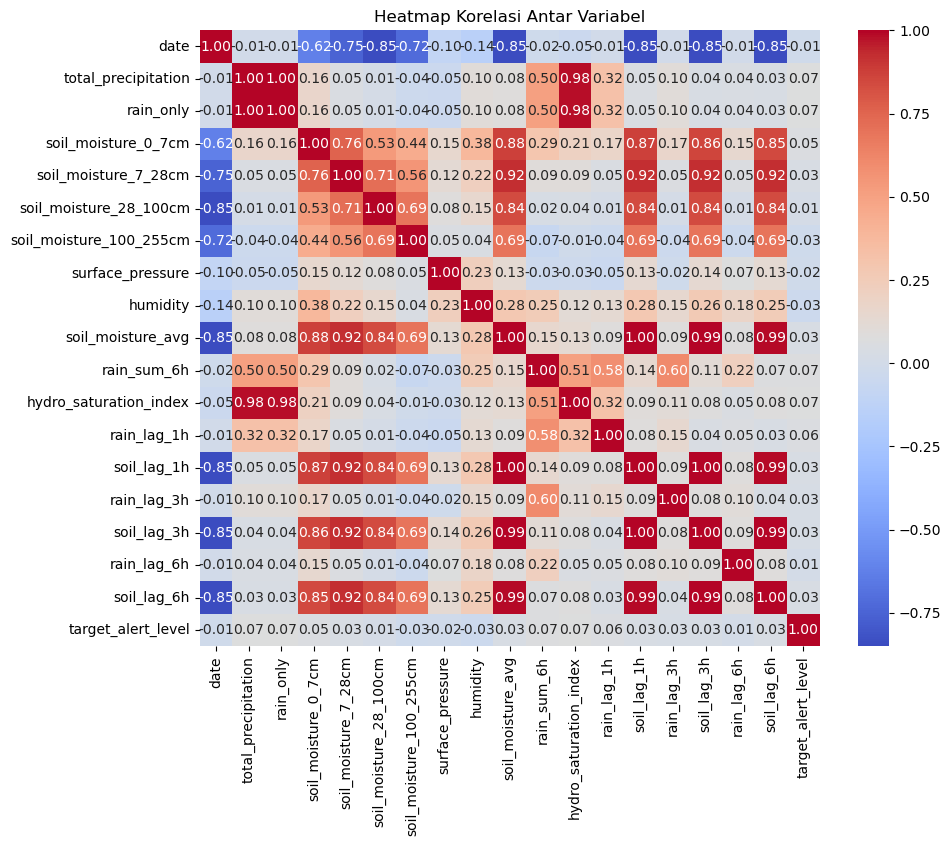

In [10]:
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Heatmap Korelasi Antar Variabel")
plt.show()

In [11]:
df.head()

,date,total_precipitation,rain_only,soil_moisture_0_7cm,soil_moisture_7_28cm,soil_moisture_28_100cm,soil_moisture_100_255cm,surface_pressure,humidity,soil_moisture_avg,rain_sum_6h,hydro_saturation_index,rain_lag_1h,soil_lag_1h,rain_lag_3h,soil_lag_3h,rain_lag_6h,soil_lag_6h,target_alert_level
6,2024-01-01 06:00:00,0.0,0.0,0.488,0.485,0.336,0.396,1008.01390,97.626724,0.42625,0.0,0.0000,0.0,0.42600,0.0,0.42700,0.0,0.42775,0
7,2024-01-01 07:00:00,0.0,0.0,0.487,0.484,0.336,0.396,1008.82050,93.085330,0.42575,0.0,0.0000,0.0,0.42625,0.0,0.42650,0.0,0.42750,0
8,2024-01-01 08:00:00,0.0,0.0,0.490,0.485,0.336,0.396,1008.83514,84.486946,0.42675,0.0,0.0000,0.0,0.42575,0.0,0.42600,0.0,0.42725,0
9,2024-01-01 09:00:00,0.1,0.1,0.489,0.485,0.336,0.396,1009.34480,74.259026,0.42650,0.1,0.0489,0.0,0.42675,0.0,0.42625,0.0,0.42700,0
10,2024-01-01 10:00:00,0.1,0.1,0.488,0.484,0.337,0.396,1009.25100,70.293070,0.42625,0.2,0.0488,0.1,0.42650,0.0,0.42575,0.0,0.42650,0
